## Data
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.
Data is taken from Kaggle!

## Note
If running on Colab, make sure you are using a cpu runtime! If in doubt go to Runtime/Change runtime type and make sure Hardware accelerator is set to None. CPU runtimes have higher RAM which is needed for this notebook. GPU runtimes will run out of memory and not execute!


In [1]:
#additional tools
import os

import networkx as nx
import pandas as pd
import numpy as np
import random
from gensim.models import Word2Vec
import itertools
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# download data needed for this example
from pathlib import Path
if not Path('paysim.csv').is_file():
  import gdown
  url = 'https://drive.google.com/uc?id=1SjY6aflQZAGKzq2aUqJq2rQCb7xM6htq'
  output = 'paysim.csv'
  gdown.download(url, output, quiet=True)


In [3]:
df = pd.read_csv('paysim.csv') #loading the dataset
df.head()
##Columns
#step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
#type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
#amount - amount of the transaction in local currency.
#nameOrig - customer who started the transaction
#oldbalanceOrg - initial balance before the transaction
#newbalanceOrig - new balance after the transaction
#nameDest - customer who is the recipient of the transaction
#oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
#newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
#isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
#isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
## Understanding the data
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

print('\n The types of flagged fraudulent transactions are {}'.format(\
list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates().values))) 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
dfFraudTransferFlagged = df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]

print ('\n The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer))) 
print ('\n The number of flagged TRANSFERs = {}'.format(len(dfFraudTransferFlagged))) 
print ('\n The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout))) 


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The types of flagged fraudulent transactions are ['TRANSFER']

 The number of fraudulent TRANSFERs = 4097

 The number of flagged TRANSFERs = 16

 The number of fraudulent CASH_OUTs = 4116


Given the fact that the flagged transactions are 16 out of 6M data, and apperantly (based on extensive data analysis on this dataset on kaggle) there is no logic behind why this 16 transactions are marked fraud, we can safley ignore those values. 

In [5]:
## Reducing some data. 


df_select = df.loc[(df['type']=='TRANSFER') | (df['type']=='CASH_OUT')] 


list_of_senders = list(df_select["nameOrig"])
list_of_dest = list(df_select['nameDest'])

dd_fraud = df_select.loc[df_select['isFraud']==1] 
list_of_senders_victom = list(dd_fraud["nameOrig"])
list_of_dest_fraud=list(dd_fraud['nameDest'])

dd_benign = df_select.loc[df_select['isFraud']==0] 
list_of_senders_benign = list(dd_benign["nameOrig"])
list_of_dest_benign=list(dd_benign['nameDest'])




In [6]:
df_select.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [7]:
##Creating Graph
G = nx.from_pandas_edgelist(df_select, "nameOrig", "nameDest", ['amount'], create_using=nx.Graph()) 
######If you want non-directed graph you do not need to provide both source and distination
######If you want all other columns work as an attribute use edge_attr=True
# len(G) 9073900  (if we keep all data) 3277509 (if we keep transfer and cash out)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3277509
Number of edges: 2770409
Average degree:   1.6906


For visulization of graph you can use the following commands. But do not attempt during the class, it will crash your session. 

In [8]:
# Uncomment these three lines:
# pos1 = nx.spring_layout(G)
# plt.axis(off)
# nx.draw_networkx(G, pos=pos1, with_labels= False, node_size=20)

#ignore
#nx.draw(G) 
#labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
#edge_labels=nx.draw_networkx_edge_labels(G,pos=nx.spring_layout(G))
#plt.show()

The first and quick detection that we can get from graphs is using egonet. 
practically we can assume any nodes that fraudester send money are related to fraud... 

In [9]:
##Create Ego network 
egog= nx.ego_graph(G, 'C553264065', radius=1, center=True, undirected=False)


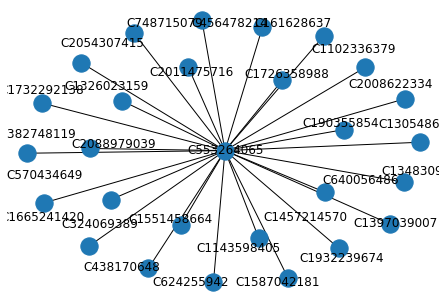

In [10]:
# show ego network
nx.draw(egog)
labels=nx.draw_networkx_labels(egog,pos=nx.spring_layout(egog))
plt.show()

In [11]:
# test and flagged results 
list_of_flaged=nx.nodes(egog)
flagged=set(list_of_flaged)
fraud=set(list_of_dest_fraud)
fraud.intersection(flagged)

{'C553264065'}

The other good way to detect fraud, is looking at the second shortest path 
between two nodes ... but it is really time confusing so we do not try it here .... 

One of the best techniques and the most used one in the industry is page rank ... page rank is coming in all sorts of techniques ... 

In [12]:
## measuring page rank
pr = nx.pagerank(G, alpha=0.85)

In [13]:
# display the first couple entries
tuple(zip(pr.items()))[:5]

((('C1305486145', 5.537177212373224e-08),),
 (('C553264065', 7.048035566035064e-06),),
 (('C840083671', 5.41323776193169e-08),),
 (('C38997010', 8.085408766230703e-06),),
 (('C905080434', 5.502872543054585e-08),))

Now first we analyse ratio of page rank between each sender and recepients ... 

In [14]:
#Finding pairwise ratio 

distances_pr= [ pr[x[0]]/pr[x[1]] for x in zip(list_of_senders,list_of_dest)]
distances_pr_f= [ pr[x[0]]/pr[x[1]] for x in zip(list_of_senders_victom,list_of_dest_fraud)]
distances_pr_n= [ pr[x[0]]/pr[x[1]] for x in zip(list_of_senders_benign,list_of_dest_benign)]

(array([0.07743422, 0.09594614, 0.00063965, 0.20625069, 0.1977777 ,
        0.26223723, 0.37999131, 0.3177054 , 0.12784854, 0.00596205]),
 array([0.        , 0.5981602 , 1.1963204 , 1.79448061, 2.39264081,
        2.99080101, 3.58896121, 4.18712142, 4.78528162, 5.38344182,
        5.98160202]),
 <a list of 10 Patch objects>)

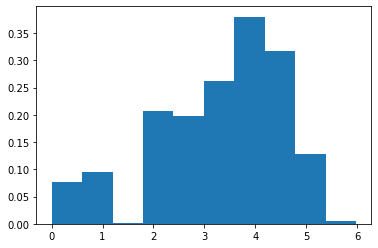

In [15]:
plt.hist(np.abs(np.log(distances_pr)),density=True)

(array([0.07579003, 0.09569397, 0.00063913, 0.20621513, 0.19791607,
        0.2625727 , 0.380571  , 0.31829659, 0.12812639, 0.00597191]),
 array([0.        , 0.5981602 , 1.1963204 , 1.79448061, 2.39264081,
        2.99080101, 3.58896121, 4.18712142, 4.78528162, 5.38344182,
        5.98160202]),
 <a list of 10 Patch objects>)

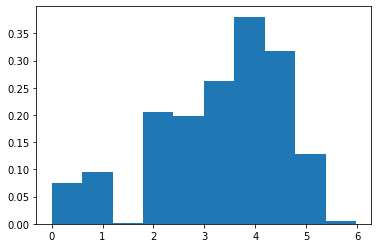

In [16]:
plt.hist(np.abs(np.log(distances_pr_n)),density=True)

(array([0.66479495, 0.00214866, 0.19015628, 0.12505193, 0.19552793,
        0.17941299, 0.19058601, 0.13708441, 0.06746788, 0.01246222]),
 array([0.        , 0.56667072, 1.13334144, 1.70001216, 2.26668288,
        2.8333536 , 3.40002432, 3.96669504, 4.53336576, 5.10003649,
        5.66670721]),
 <a list of 10 Patch objects>)

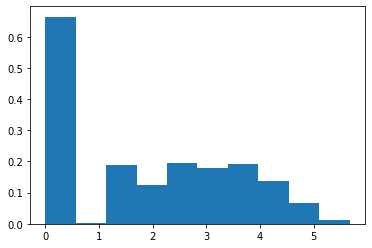

In [17]:
plt.hist(np.abs(np.log(distances_pr_f)),density=True)

So what we can conclude the fraudulant activity is most likly to happen for log(pr ratio)~0 
#########################


We can also measure weighted page rank. 
Depends on your data, and insight you have from your models you can use total money sent, or number of interactions between two nodes, etc as a weight for your page rank. 

In [18]:
new_df= df_select.groupby(['nameOrig','nameDest'], as_index=False).agg({"amount": "sum", "isFraud": "unique"})


In [19]:
new_df['log_amount'] = np.log10(new_df['amount']+1)
new_df.head()

,nameOrig,nameDest,amount,isFraud,log_amount
0,C1000000639,C785826240,244486.46,[0],5.388257
1,C1000004053,C1128041097,211189.64,[0],5.324675
2,C1000004530,C1643839147,93865.13,[0],4.972509
3,C1000005353,C292963054,3228390.11,[0],6.508986
4,C1000005555,C1091802600,233109.79,[0],5.367562


In [20]:
#measuring weighted page rank, here we use amount of money sent as weight
G2 = nx.from_pandas_edgelist(new_df, "nameOrig", "nameDest", ['log_amount'], create_using=nx.Graph()) 
print(nx.info(G2))
wpr = nx.pagerank(G2, alpha=0.85,weight='weight')

Name: 
Type: Graph
Number of nodes: 3277509
Number of edges: 2770409
Average degree:   1.6906


We run similar analysis to page rank before 

In [21]:
distances_wpr= [ wpr[x[0]]/wpr[x[1]] for x in zip(list_of_senders,list_of_dest)]
distances_wpr_f= [ wpr[x[0]]/wpr[x[1]] for x in zip(list_of_senders_victom,list_of_dest_fraud)]
distances_wpr_n= [ wpr[x[0]]/wpr[x[1]] for x in zip(list_of_senders_benign,list_of_dest_benign)]

(array([0.07743422, 0.09594614, 0.00063965, 0.20625069, 0.1977777 ,
        0.26223723, 0.37999131, 0.3177054 , 0.12784854, 0.00596205]),
 array([0.        , 0.5981602 , 1.1963204 , 1.79448061, 2.39264081,
        2.99080101, 3.58896121, 4.18712142, 4.78528162, 5.38344182,
        5.98160202]),
 <a list of 10 Patch objects>)

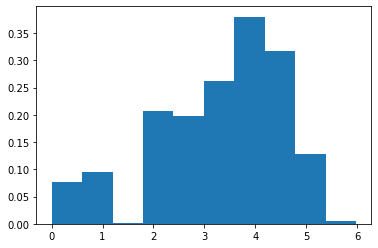

In [22]:
plt.hist(np.abs(np.log(distances_wpr)),density=True)

(array([0.66479495, 0.00214866, 0.19015628, 0.12505193, 0.19552793,
        0.17941299, 0.19058601, 0.13708441, 0.06746788, 0.01246222]),
 array([0.        , 0.56667072, 1.13334144, 1.70001216, 2.26668288,
        2.8333536 , 3.40002432, 3.96669504, 4.53336576, 5.10003649,
        5.66670721]),
 <a list of 10 Patch objects>)

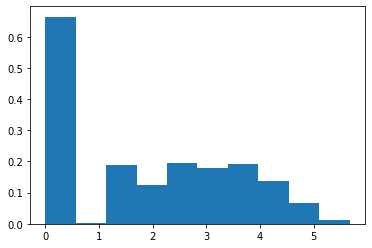

In [23]:
plt.hist(np.abs(np.log(distances_wpr_f)),density=True)

(array([0.07579003, 0.09569397, 0.00063913, 0.20621513, 0.19791607,
        0.2625727 , 0.380571  , 0.31829659, 0.12812639, 0.00597191]),
 array([0.        , 0.5981602 , 1.1963204 , 1.79448061, 2.39264081,
        2.99080101, 3.58896121, 4.18712142, 4.78528162, 5.38344182,
        5.98160202]),
 <a list of 10 Patch objects>)

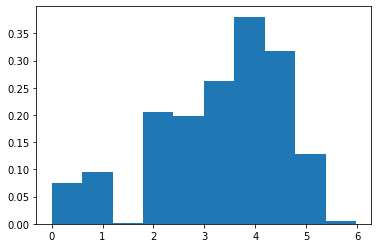

In [24]:
plt.hist(np.abs(np.log(distances_wpr_n)),density=True)

In [25]:
target_list = [x for x in zip(list_of_senders,list_of_dest) if np.log(wpr[x[0]]/wpr[x[1]]) < 0.5]
flagged=set(target_list)
fraud=set(list_of_dest_fraud)
fraud.intersection(flagged)

set()

## Deepwalk


In [26]:
!git clone https://github.com/shenweichen/GraphEmbedding

Cloning into 'GraphEmbedding'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 171 (delta 6), reused 15 (delta 3), pack-reused 146
Receiving objects: 100% (171/171), 673.49 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
# # takes a lot of time and RAM to run... This will not work in Colab
# from GraphEmbedding.ge.models import DeepWalk
# model = DeepWalk(G,walk_length=10,num_walks=80,workers=1)#init model
# model.train(window_size=5,iter=3)# train model
# embeddings = model.get_embeddings()# get embedding vectors

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
